In [1480]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_curve


In [1481]:
df = pd.read_csv('train.csv', index_col='id')
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15702656.0,Nwora,567.0,France,Male,33.0,9.0,0.00,2.0,1.0,0.0,156792.89,0.0
1,15647965.0,Yevdokimova,628.0,France,Female,38.0,3.0,0.00,1.0,1.0,1.0,51987.99,1.0
2,15798834.0,Ch'iu,635.0,France,Female,29.0,3.0,0.00,2.0,1.0,1.0,113079.19,0.0
3,15672056.0,Hsia,681.0,France,Male,28.0,6.0,0.00,2.0,1.0,0.0,14081.64,0.0
4,15759537.0,Okwudilichukwu,587.0,France,Female,27.0,5.0,0.00,2.0,1.0,0.0,158958.90,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,15733888.0,H?,581.0,France,Male,35.0,1.0,0.00,2.0,1.0,0.0,161653.50,0.0
14996,15740164.0,Ch'in,806.0,Germany,Male,42.0,1.0,129120.64,2.0,1.0,1.0,161642.08,0.0
14997,15629002.0,Shubin,620.0,France,Female,29.0,7.0,0.00,2.0,1.0,1.0,161579.85,0.0


# 1. EDA

In [1482]:
df.info()       

<class 'pandas.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       15000 non-null  float64
 1   Surname          15000 non-null  str    
 2   CreditScore      15000 non-null  float64
 3   Geography        15000 non-null  str    
 4   Gender           15000 non-null  str    
 5   Age              15000 non-null  float64
 6   Tenure           15000 non-null  float64
 7   Balance          15000 non-null  float64
 8   NumOfProducts    15000 non-null  float64
 9   HasCrCard        15000 non-null  float64
 10  IsActiveMember   15000 non-null  float64
 11  EstimatedSalary  15000 non-null  float64
 12  Exited           15000 non-null  float64
dtypes: float64(10), str(3)
memory usage: 1.7 MB


In [1483]:
df.isna().sum()     # no missing values

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [1484]:
df.duplicated().sum()  # no duplicated rows

np.int64(0)

In [1485]:
df.describe()   

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.579454e+07,657.856800,37.710133,5.018667,42338.107539,1.590533,0.779133,0.496000,116944.059867,0.198467
std,1.268495e+07,72.678739,8.144880,2.787407,59703.047751,0.525822,0.414845,0.500001,46047.485455,0.398859
min,1.567151e+05,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.563435e+07,602.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,82644.332500,0.000000
50%,1.568947e+07,661.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,122449.420000,0.000000
75%,1.575682e+07,707.000000,42.000000,7.000000,109636.342500,2.000000,1.000000,1.000000,155703.022500,0.000000
max,1.569172e+09,850.000000,72.000000,10.000000,187911.550000,5.000000,1.000000,1.000000,885120.790000,1.000000


In [1486]:
df[df['EstimatedSalary'] > 200_000]     # only one customer's salary is more than 200k and 885k, it is considered as an outlier

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
6309,15662641.0,Onwuka,774.0,France,Male,33.0,1.0,0.0,2.0,1.0,0.0,885120.79,0.0


In [1487]:
df = df[df['EstimatedSalary'] <= 200_000]  # dropping outlier row

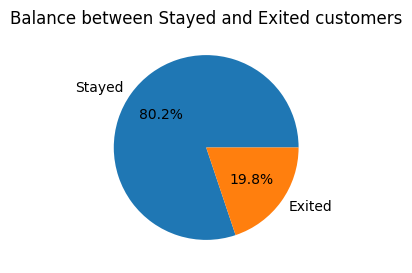

In [1488]:
churn_rate = df['Exited'].value_counts() / len(df) * 100        # dataset is highly imbalanced, 80/20

plt.figure(figsize=(3,3))
plt.pie(churn_rate, labels = ['Stayed', 'Exited'], autopct='%1.1f%%')
plt.title('Balance between Stayed and Exited customers')
plt.show()

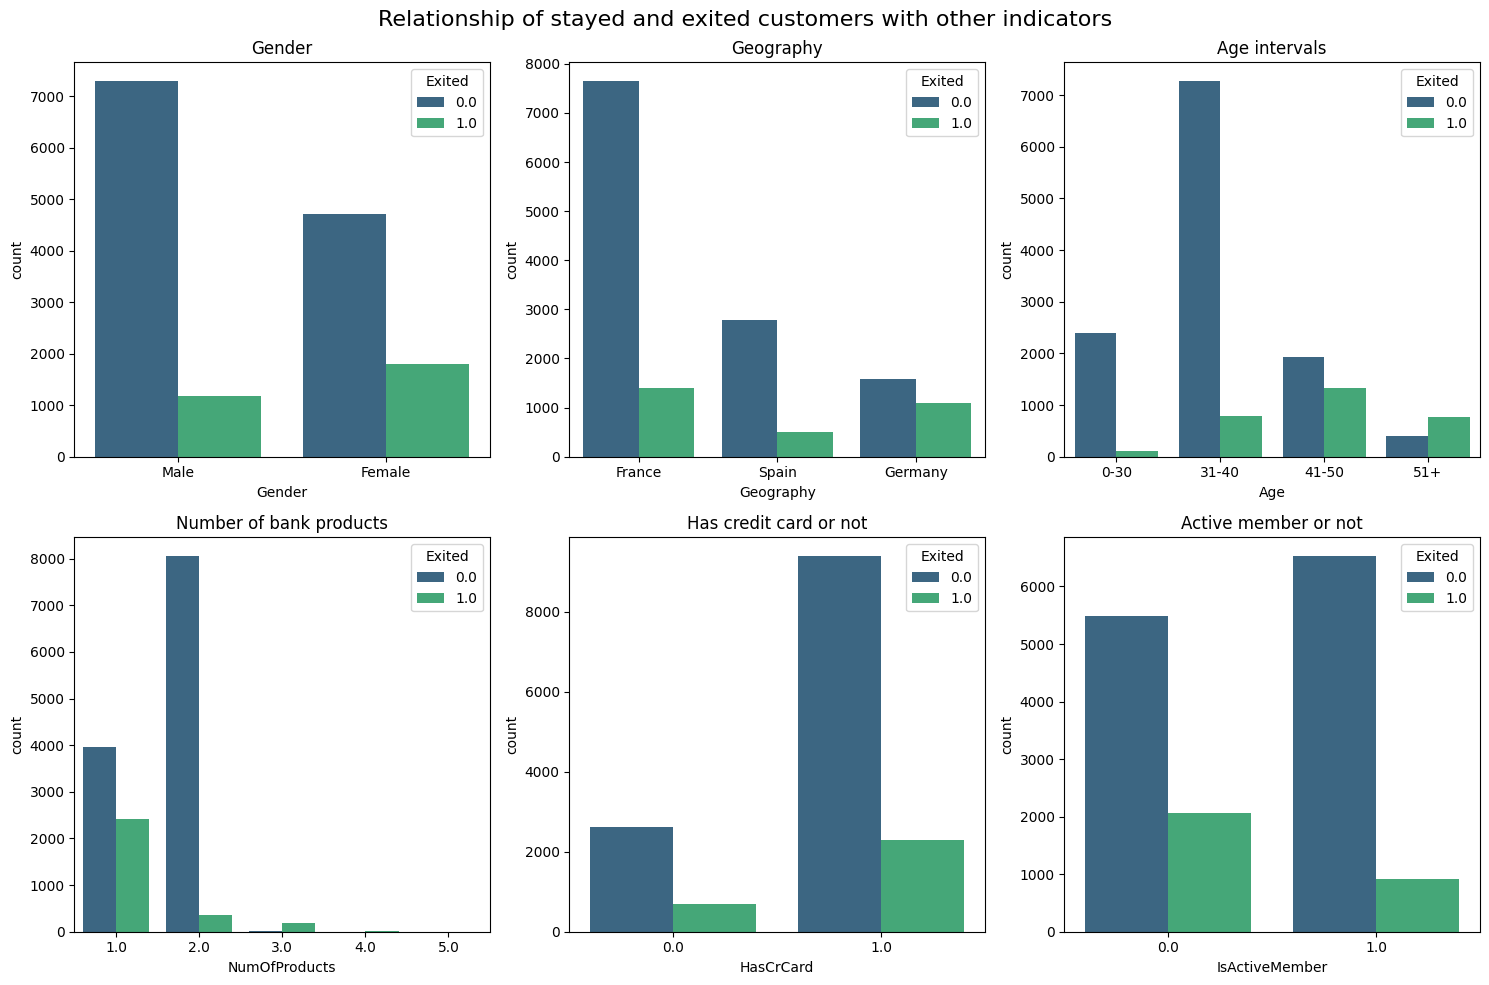

In [1489]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
fig.suptitle('Relationship of stayed and exited customers with other indicators', fontsize=16)

sns.countplot(x='Gender', hue='Exited', palette='viridis', data=df, ax=axes[0,0])
axes[0,0].set_title('Gender')

sns.countplot(x='Geography', hue='Exited', palette='viridis', data=df, ax=axes[0,1])
axes[0,1].set_title('Geography')

bins=[0, 30, 40, 50, 120]
labels = ["0-30", "31-40", "41-50", "51+"]
sns.countplot(x=pd.cut(df['Age'], bins=bins, labels=labels, right=True), hue='Exited', palette='viridis', data=df, ax=axes[0,2])
axes[0,2].set_title('Age intervals')

sns.countplot(x='NumOfProducts', hue='Exited', palette='viridis', data=df, ax=axes[1,0])
axes[1,0].set_title('Number of bank products')

sns.countplot(x='HasCrCard', hue='Exited', palette='viridis', data=df, ax=axes[1,1])
axes[1,1].set_title('Has credit card or not')

sns.countplot(x='IsActiveMember', hue='Exited', palette='viridis', data=df, ax=axes[1,2])
axes[1,2].set_title('Active member or not')

plt.tight_layout()
plt.show()

According to the graph above, the customers who are more likely to churn are:
- female customers
- customers in Germany
- customers over 40 years old
- customers who have only one bank product (customers with two products are less likely to churn)
- inactive customers

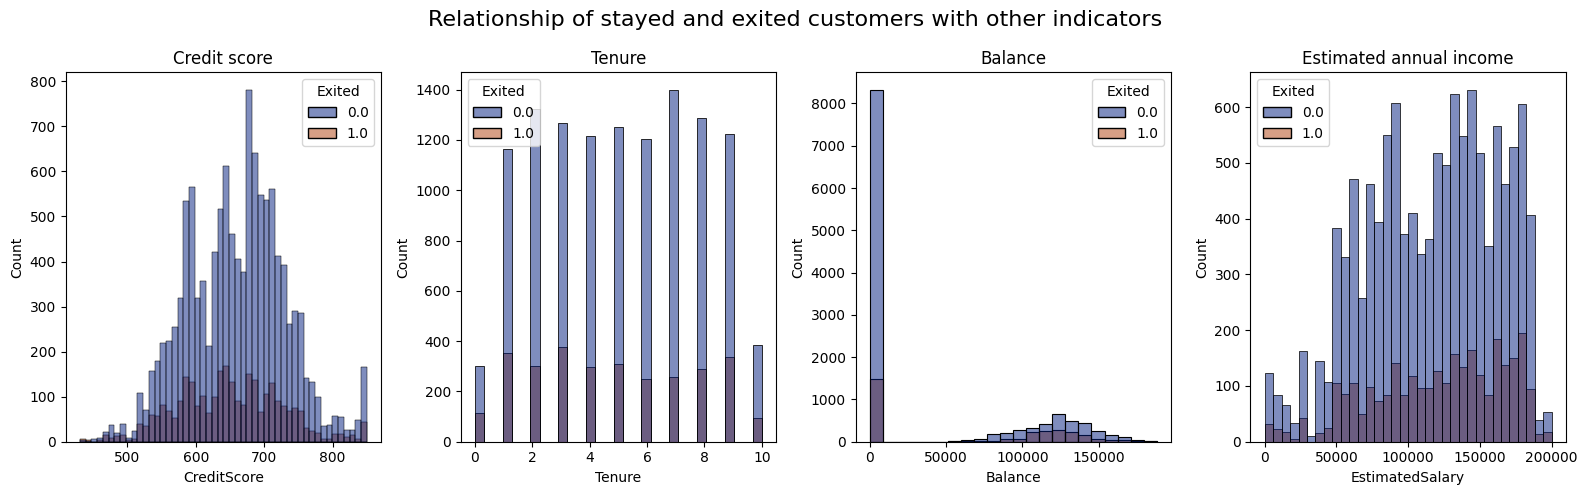

In [1490]:
fig, ax = plt.subplots(1, 4, figsize=(16,5))
fig.suptitle('Relationship of stayed and exited customers with other indicators', fontsize=16)

sns.histplot(x='CreditScore', hue='Exited', palette='dark', data=df, ax=ax[0])
ax[0].set_title('Credit score')

sns.histplot(x='Tenure', hue='Exited', palette='dark', data=df, ax=ax[1])
ax[1].set_title('Tenure')

sns.histplot(x='Balance', hue='Exited', palette='dark', data=df, ax=ax[2])
ax[2].set_title('Balance')

sns.histplot(x='EstimatedSalary', hue='Exited', palette='dark', data=df, ax=ax[3])
ax[3].set_title('Estimated annual income')

plt.tight_layout()
plt.show()

- More than half of all customers have a balance of zero. This is reasonable because they may have accounts with other banks or could be new customers

- A portion of customers have annual income below 12k. This can be explained by groups such as students, retirees, dependents, people rely on savings

# 2. Model

In [1491]:
X = df.drop('Exited', axis=1)
y = df['Exited'].copy()

In [1492]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 0.8/0.2 - train/test split

In [1493]:
def feature_transformer(x):
    """Apply feature engineering"""

    x["Female"] = (x["Gender"] == "Female")                      # encoding categorical 'Gender' instead of one_hot encoding
 
    x['NotTwoProduct'] = (x["NumOfProducts"] != 2)               # extra feature to show that customers with other than two products are more likely to churn

    x["Age_over_40"] = (x['Age'].between(40, 100))               # extra feature to show customers aged over 40 are more likely to churn

    x["ZeroBalance"] = (x["Balance"] == 0)                       # extra feature to show zero balance customers

    return x.drop(columns=['CustomerId', 'Surname', 'Gender'])   # 'CustomerId' and 'Surname' are indicators, 'Gender' is replaced with 'Female'

transformer = FunctionTransformer(feature_transformer)

cat_attribs = ['Geography']                                      # one hot encoding categorical 'Geography'

preprocessing = ColumnTransformer([                              # tree based models do not need feature scaling
    ('cats', OneHotEncoder(handle_unknown='ignore'), cat_attribs)
], remainder='passthrough'                                       # other features are passed directly to pipeline 
)


XGBoost was selected as the model

Due to class imbalance, the minority class (exited customers) would contribute less to the loss function during training. To address this, ``scale_pos_weight`` was applied to increase the penalty for misclassifying class 1, improving the model’s sensitivity to churn cases.

In [1494]:
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]   # ratio of majority/minority class for scale_pos_weight

In [1495]:
pipeline = Pipeline([                                           # pipeline
    ('feat_eng', transformer),
    ('preprocessor', preprocessing),
    ('model', XGBClassifier(scale_pos_weight=ratio))
])

In [1496]:
# choosing best parameters using GridSearchSV
param_grid = {                                          
    'model__n_estimators': [10, 20, 50, 100],
    'model__max_depth': [3, 5, 7, 9],
    'model__learning_rate': [0.01, 0.05, 0.1],
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1   # use all CPU cores
)

grid.fit(X_train, y_train)
print(f'Best parameters: {grid.best_params_}')

Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 100}


In [1497]:
pipeline = Pipeline([                                           # pipeline
    ('feat_eng', transformer),
    ('preprocessor', preprocessing),
    ('model', XGBClassifier(scale_pos_weight=ratio, n_estimators = 100, max_depth = 7, learning_rate=0.1))
])

In [1498]:
pipeline.fit(X_train, y_train)                  # training model with best parameters

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feat_eng', ...), ('preprocessor', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function fea...0018D889DC180>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments 

# 3. Model evaluation

As the target variable is binary and business decisions are ultimately binary in nature, the confusion matrix provides interpretable summary of false positive and false negative predictions.

The model produced 101 false negatives (actual defaulters predicted as repayers).

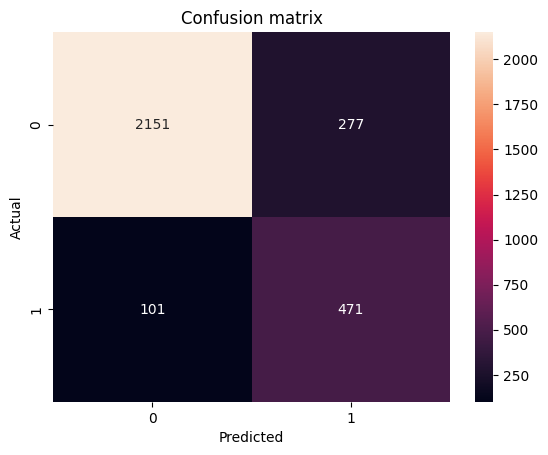

In [1499]:
y_pred = pipeline.predict(X_test)

sns.heatmap(confusion_matrix(y_test, y_pred), fmt='d', annot=True)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [1500]:
accuracy = accuracy_score(y_test, y_pred)           # Accuracy score
print(f'Accuracy: {accuracy}')

Accuracy: 0.874


c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_plotting.py:385: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


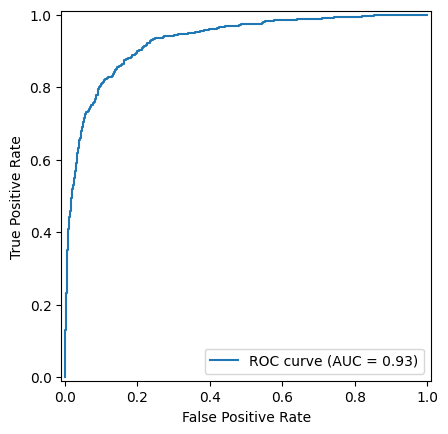

In [1501]:
# [:, 1] selects the probability of class 1 (defaulters), since we are predicting repayment risk.

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve').plot()
plt.show()

The ROC curve demonstrates the trade-off between recall (True Positive Rate) and the False Positive Rate. A steep curve near the top-left corner indicates the model is highly effective at identifying defaulters (high recall) while minimizing incorrect flags of repayers.

The AUC score of 0.93 means the model is reliable in distinguishing between repayers and defaulters.

# 4. Predicting unseen dataset

In [1502]:
df_test = pd.read_csv('test.csv', index_col='id')
df_test

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
15000,15732563.0,Hs?,707.0,Germany,Male,21.0,4.0,114513.66,2.0,1.0,0.0,176692.87
15001,15727041.0,Ma,678.0,Germany,Male,33.0,5.0,142510.50,1.0,0.0,0.0,52820.13
15002,15753679.0,K?,636.0,Spain,Male,45.0,9.0,0.00,2.0,1.0,1.0,125062.02
15003,15581554.0,H?,697.0,Spain,Male,46.0,8.0,0.00,2.0,1.0,0.0,131647.41
15004,15773723.0,Bellucci,553.0,Spain,Male,31.0,2.0,0.00,2.0,1.0,0.0,58814.41
...,...,...,...,...,...,...,...,...,...,...,...,...
24995,15604515.0,Palerma,583.0,France,Female,46.0,4.0,0.00,2.0,1.0,1.0,175071.29
24996,15795939.0,Chizuoke,513.0,France,Male,42.0,4.0,148159.71,2.0,1.0,1.0,149740.22
24997,15584555.0,Tuan,559.0,Spain,Male,52.0,7.0,117561.49,3.0,1.0,0.0,163534.36


In [1503]:
default_rate = pipeline.predict_proba(df_test)[:, 1]

In [1506]:
df_predict = pd.read_csv('sample_submission.csv', index_col='id')
df_predict['Exited'] = default_rate

In [1507]:
df_predict.to_csv('loan_default_rate.csv', index='id')